In [54]:
import pandas as pd
from scipy.signal import butter, filtfilt, iirnotch
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import welch
from scipy.signal import spectrogram

# Load the CSV file
df = pd.read_csv('eeg_data.csv')

# Display the first few rows
print(df.head())

   Differential1  Differential2  Differential3          Local_Timestamp
0           2151           1791           1973  2024-11-03 21:42:02.940
1           2562           1908           2381  2024-11-03 21:42:02.943
2           2603           2196           2661  2024-11-03 21:42:02.945
3           2160           1936           1911  2024-11-03 21:42:02.947
4           2554           1824           1871  2024-11-03 21:42:02.949


In [55]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17991 entries, 0 to 17990
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Differential1    17991 non-null  int64 
 1   Differential2    17991 non-null  int64 
 2   Differential3    17991 non-null  int64 
 3   Local_Timestamp  17991 non-null  object
dtypes: int64(3), object(1)
memory usage: 562.3+ KB
None
       Differential1  Differential2  Differential3
count   17991.000000   17991.000000   17991.000000
mean     2436.658107    2002.175421    2173.209716
std       205.115594     213.490485     240.890200
min      1867.000000    1424.000000    1459.000000
25%      2258.000000    1830.000000    1971.000000
50%      2457.000000    1991.000000    2127.000000
75%      2587.000000    2153.500000    2384.000000
max      3216.000000    2869.000000    2944.000000


In [56]:
# Convert timestamp to datetime
df['Local_Timestamp'] = pd.to_datetime(df['Local_Timestamp'])

# Set as index
df.set_index('Local_Timestamp', inplace=True)

# Check the index
print(df.index)

DatetimeIndex(['2024-11-03 21:42:02.940000', '2024-11-03 21:42:02.943000',
               '2024-11-03 21:42:02.945000', '2024-11-03 21:42:02.947000',
               '2024-11-03 21:42:02.949000', '2024-11-03 21:42:02.950000',
               '2024-11-03 21:42:02.951000', '2024-11-03 21:42:02.952000',
               '2024-11-03 21:42:02.953000', '2024-11-03 21:42:02.955000',
               ...
               '2024-11-03 21:47:02.455000', '2024-11-03 21:47:02.460000',
               '2024-11-03 21:47:02.464000', '2024-11-03 21:47:02.467000',
               '2024-11-03 21:47:02.471000', '2024-11-03 21:47:02.514000',
               '2024-11-03 21:47:02.516000', '2024-11-03 21:47:02.517000',
               '2024-11-03 21:47:02.518000', '2024-11-03 21:47:02.519000'],
              dtype='datetime64[ns]', name='Local_Timestamp', length=17991, freq=None)


In [28]:
# Calculate the baseline (e.g., mean of the first few seconds without electrodes)
baseline = df[['Differential1', 'Differential2', 'Differential3']].mean()

# Subtract the baseline
df[['Differential1', 'Differential2', 'Differential3']] = df[['Differential1', 'Differential2', 'Differential3']] - baseline

print(df.head())

                         Differential1  Differential2  Differential3
Local_Timestamp                                                     
2024-11-03 21:42:02.940    -285.658107    -211.175421    -200.209716
2024-11-03 21:42:02.943     125.341893     -94.175421     207.790284
2024-11-03 21:42:02.945     166.341893     193.824579     487.790284
2024-11-03 21:42:02.947    -276.658107     -66.175421    -262.209716
2024-11-03 21:42:02.949     117.341893    -178.175421    -302.209716


In [58]:
# Sampling rate and Nyquist frequency
fs = 256  # Hz
nyq = 0.5 * fs  # 128 Hz

# Bandpass filter parameters
lowcut = 7  # Hz
highcut = 31.0  # Hz

# Notch filter parameters (e.g., 50 Hz or 60 Hz)
notch_freq = 60.0  # Hz (Change to 60.0 if applicable)
quality_factor = 30.0  # Quality factor for notch filter

In [59]:
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    # Design Butterworth bandpass filter
    b, a = butter(order, [low, high], btype='band')
    # Apply zero-phase filter to avoid phase distortion
    y = filtfilt(b, a, data)
    return y

# Apply the bandpass filter to each differential channel
for diff in ['Differential1', 'Differential2', 'Differential3']:
    df[f'filtered_{diff}'] = bandpass_filter(df[diff], lowcut, highcut, fs, order=5)

print(df[['filtered_Differential1', 'filtered_Differential2', 'filtered_Differential3']].head())

                         filtered_Differential1  filtered_Differential2  \
Local_Timestamp                                                           
2024-11-03 21:42:02.940                1.714876                9.169269   
2024-11-03 21:42:02.943              110.085037               78.999840   
2024-11-03 21:42:02.945              194.998720              132.587707   
2024-11-03 21:42:02.947              241.694900              160.754303   
2024-11-03 21:42:02.949              248.521371              164.234527   

                         filtered_Differential3  
Local_Timestamp                                  
2024-11-03 21:42:02.940               15.056555  
2024-11-03 21:42:02.943              118.435736  
2024-11-03 21:42:02.945              193.748323  
2024-11-03 21:42:02.947              223.573830  
2024-11-03 21:42:02.949              206.004907  


In [60]:
def notch_filter(data, freq, fs, quality=30):
    nyq = 0.5 * fs
    # Design notch filter
    b, a = iirnotch(freq / nyq, quality)
    # Apply zero-phase filter
    y = filtfilt(b, a, data)
    return y

# Check if notch frequency is below Nyquist frequency
if notch_freq < nyq:
    for diff in ['filtered_Differential1', 'filtered_Differential2', 'filtered_Differential3']:
        df[diff] = notch_filter(df[diff], notch_freq, fs, quality=quality_factor)
else:
    print(f"Notch frequency {notch_freq} Hz is above Nyquist frequency {nyq} Hz. Skipping notch filter.")

print(df[['filtered_Differential1', 'filtered_Differential2', 'filtered_Differential3']].head())


                         filtered_Differential1  filtered_Differential2  \
Local_Timestamp                                                           
2024-11-03 21:42:02.940                1.412409                9.079252   
2024-11-03 21:42:02.943              110.311624               79.104365   
2024-11-03 21:42:02.945              195.293752              132.667705   
2024-11-03 21:42:02.947              241.478455              160.631242   
2024-11-03 21:42:02.949              248.141419              164.098669   

                         filtered_Differential3  
Local_Timestamp                                  
2024-11-03 21:42:02.940               14.815618  
2024-11-03 21:42:02.943              118.412330  
2024-11-03 21:42:02.945              193.929802  
2024-11-03 21:42:02.947              223.562863  
2024-11-03 21:42:02.949              205.761626  


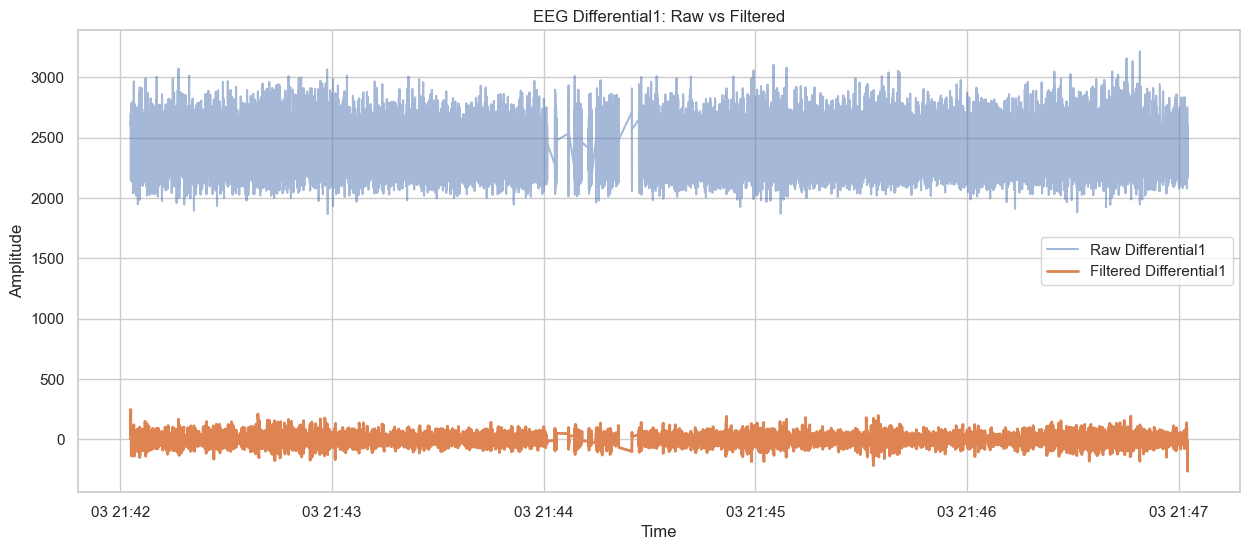

In [61]:
sns.set(style="whitegrid")

# Plot raw vs filtered for differential1
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Differential1'], label='Raw Differential1', alpha=0.5)
plt.plot(df.index, df['filtered_Differential1'], label='Filtered Differential1', linewidth=2)
plt.title('EEG Differential1: Raw vs Filtered')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


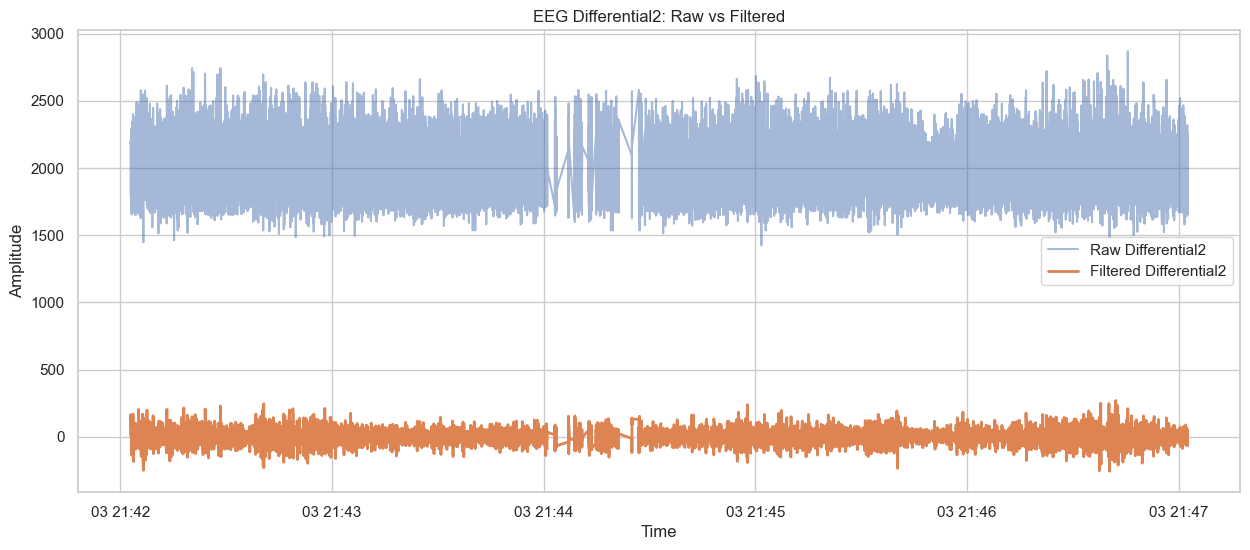

In [62]:
# Plot raw vs filtered for differential2
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Differential2'], label='Raw Differential2', alpha=0.5)
plt.plot(df.index, df['filtered_Differential2'], label='Filtered Differential2', linewidth=2)
plt.title('EEG Differential2: Raw vs Filtered')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

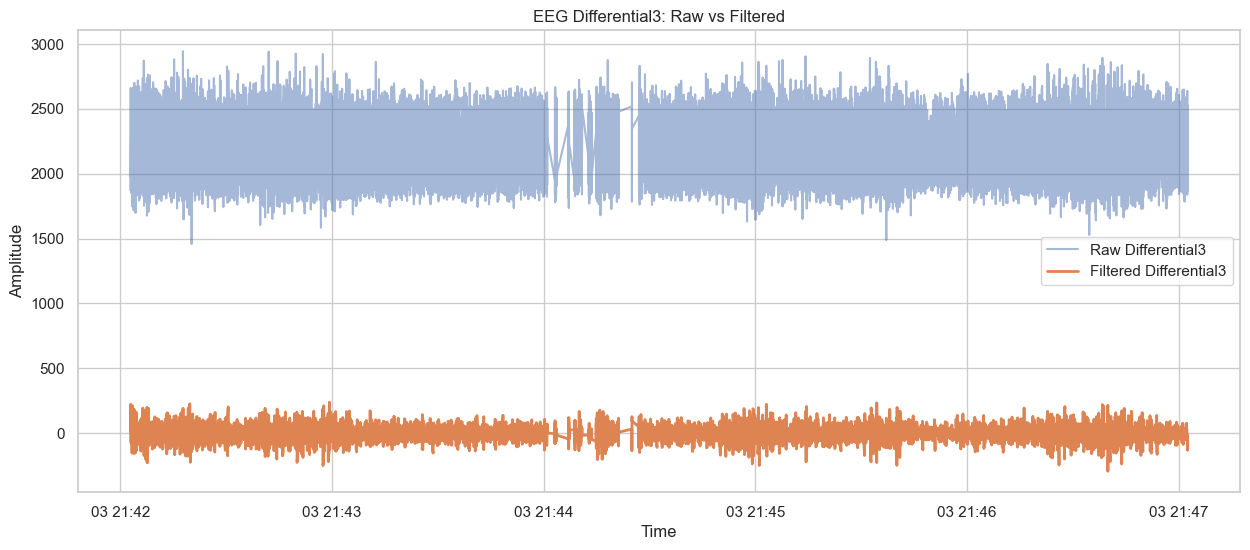

In [63]:
# Plot raw vs filtered for differential3
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Differential3'], label='Raw Differential3', alpha=0.5)
plt.plot(df.index, df['filtered_Differential3'], label='Filtered Differential3', linewidth=2)
plt.title('EEG Differential3: Raw vs Filtered')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

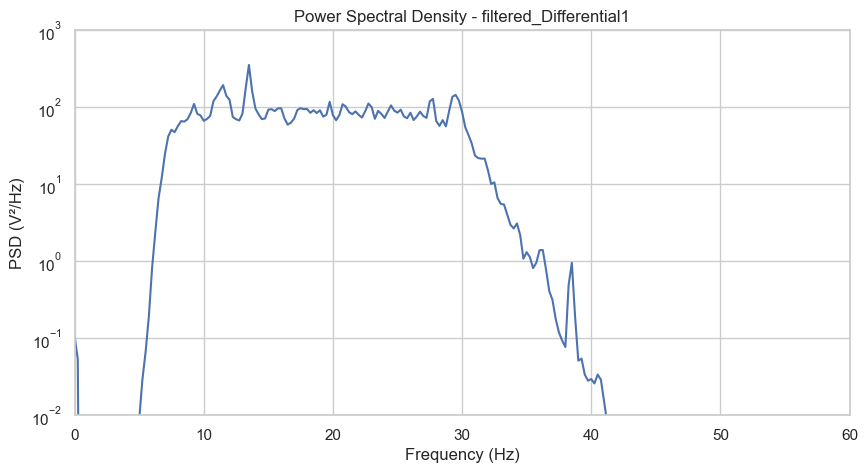

In [64]:
# Function to plot PSD
def plot_psd(data, fs, title):
    f, Pxx = welch(data, fs, nperseg=1024)
    plt.figure(figsize=(10, 5))
    plt.semilogy(f, Pxx)
    plt.title(f'Power Spectral Density - {title}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD (V²/Hz)')
    plt.xlim(0, 60)  # Adjust based on your analysis needs
    plt.ylim(10**-2, 10**3)
    plt.show()

# Plot PSD for filtered_differential1
plot_psd(df['filtered_Differential1'], fs, 'filtered_Differential1')


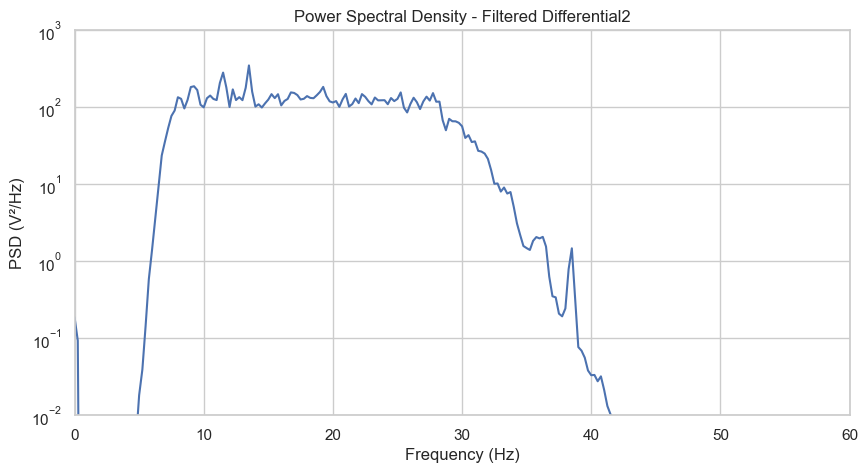

In [65]:
# Function to plot PSD
def plot_psd(data, fs, title):
    f, Pxx = welch(data, fs, nperseg=1024)
    plt.figure(figsize=(10, 5))
    plt.semilogy(f, Pxx)
    plt.title(f'Power Spectral Density - {title}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD (V²/Hz)')
    plt.xlim(0, 60)  # Adjust based on your analysis needs
    plt.ylim(10**-2, 10**3)
    plt.show()

# Plot PSD for filtered_differential2
plot_psd(df['filtered_Differential2'], fs, 'Filtered Differential2')

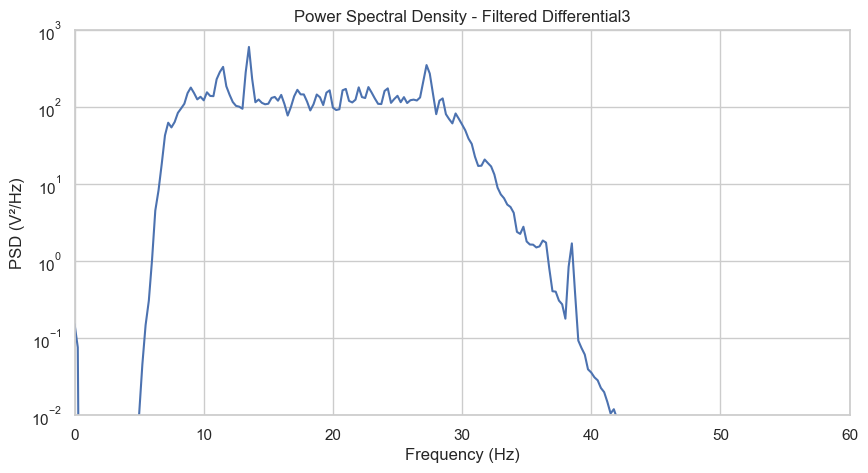

In [66]:
# Function to plot PSD
def plot_psd(data, fs, title):
    f, Pxx = welch(data, fs, nperseg=1024)
    plt.figure(figsize=(10, 5))
    plt.semilogy(f, Pxx)
    plt.title(f'Power Spectral Density - {title}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD (V²/Hz)')
    plt.xlim(0, 60)  # Adjust based on your analysis needs
    plt.ylim(10**-2, 10**3)
    plt.show()

# Plot PSD for filtered_differential3
plot_psd(df['filtered_Differential3'], fs, 'Filtered Differential3')

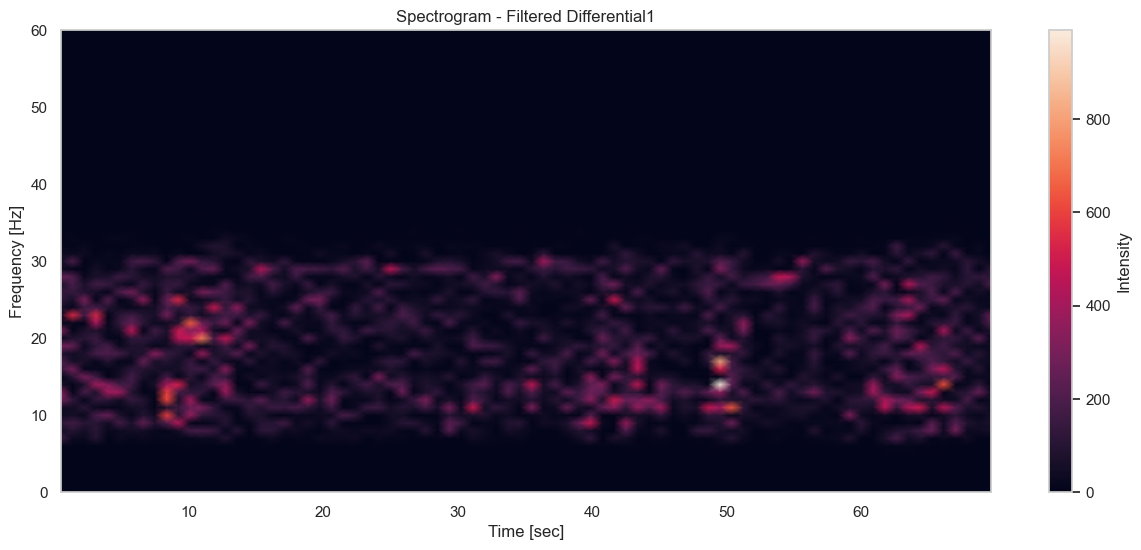

In [67]:
# Function to plot spectrogram
def plot_spectrogram(data, fs, title):
    f, t, Sxx = spectrogram(data, fs)
    plt.figure(figsize=(15, 6))
    plt.pcolormesh(t, f, Sxx, shading='gouraud')
    plt.title(f'Spectrogram - {title}')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.ylim(0, 60)  # Adjust based on your analysis needs
    plt.colorbar(label='Intensity')
    plt.show()

# Plot spectrogram for filtered_differential1
plot_spectrogram(df['filtered_Differential1'], fs, 'Filtered Differential1')



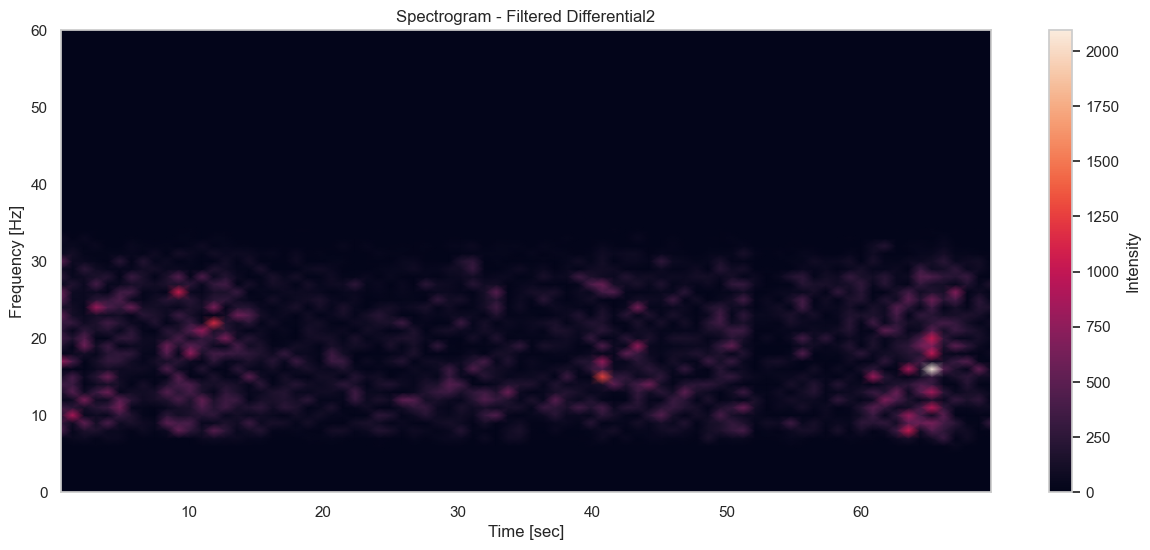

In [68]:
# Function to plot spectrogram
def plot_spectrogram(data, fs, title):
    f, t, Sxx = spectrogram(data, fs)
    plt.figure(figsize=(15, 6))
    plt.pcolormesh(t, f, Sxx, shading='gouraud')
    plt.title(f'Spectrogram - {title}')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.ylim(0, 60)  # Adjust based on your analysis needs
    plt.colorbar(label='Intensity')
    plt.show()

# Plot spectrogram for filtered_differential3
plot_spectrogram(df['filtered_Differential2'], fs, 'Filtered Differential2')

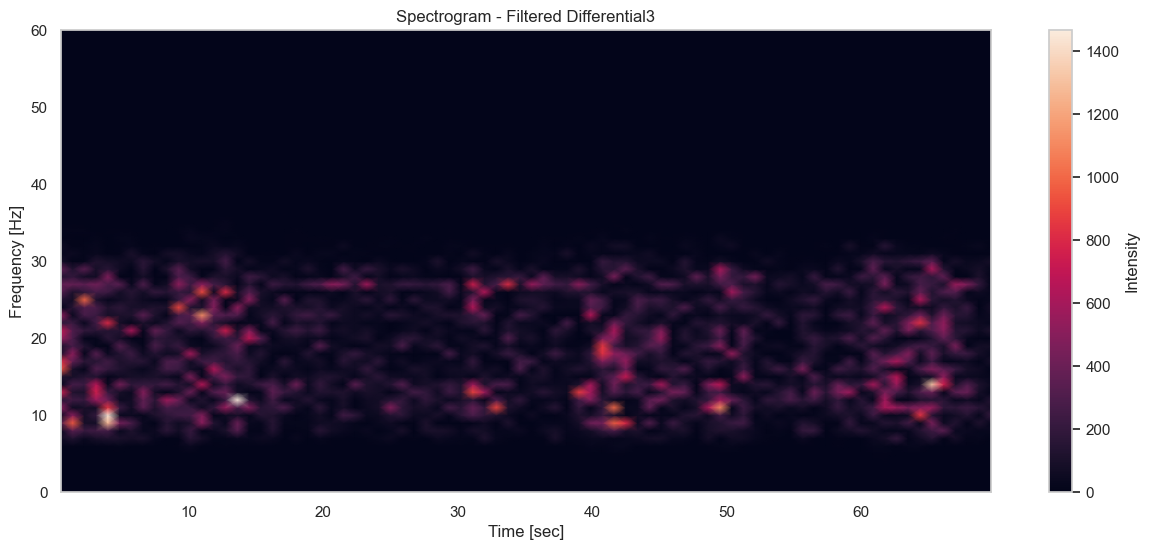

In [69]:
# Function to plot spectrogram
def plot_spectrogram(data, fs, title):
    f, t, Sxx = spectrogram(data, fs)
    plt.figure(figsize=(15, 6))
    plt.pcolormesh(t, f, Sxx, shading='gouraud')
    plt.title(f'Spectrogram - {title}')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.ylim(0, 60)  # Adjust based on your analysis needs
    plt.colorbar(label='Intensity')
    plt.show()

# Plot spectrogram for filtered_differential3
plot_spectrogram(df['filtered_Differential3'], fs, 'Filtered Differential3')

In [110]:
filtered_csv_path = './eeg_data_filtered.csv' 
df[['filtered_Differential1', 'filtered_Differential2', 'filtered_Differential3']].to_csv(filtered_csv_path, index=True)


,Differential1,Differential2,Differential3,filtered_Differential1,filtered_Differential2,filtered_Differential3
Local_Timestamp,,,,,,
2024-11-03 21:42:02.940,-285.658107,-211.175421,-200.209716,15.658808,129.157727,142.617970
2024-11-03 21:42:02.943,125.341893,-94.175421,207.790284,188.095978,252.019121,321.789948
2024-11-03 21:42:02.945,166.341893,193.824579,487.790284,313.352572,334.157055,426.700451
2024-11-03 21:42:02.947,-276.658107,-66.175421,-262.209716,372.873277,360.693744,437.130256
2024-11-03 21:42:02.949,117.341893,-178.175421,-302.209716,381.822009,347.131115,390.946201


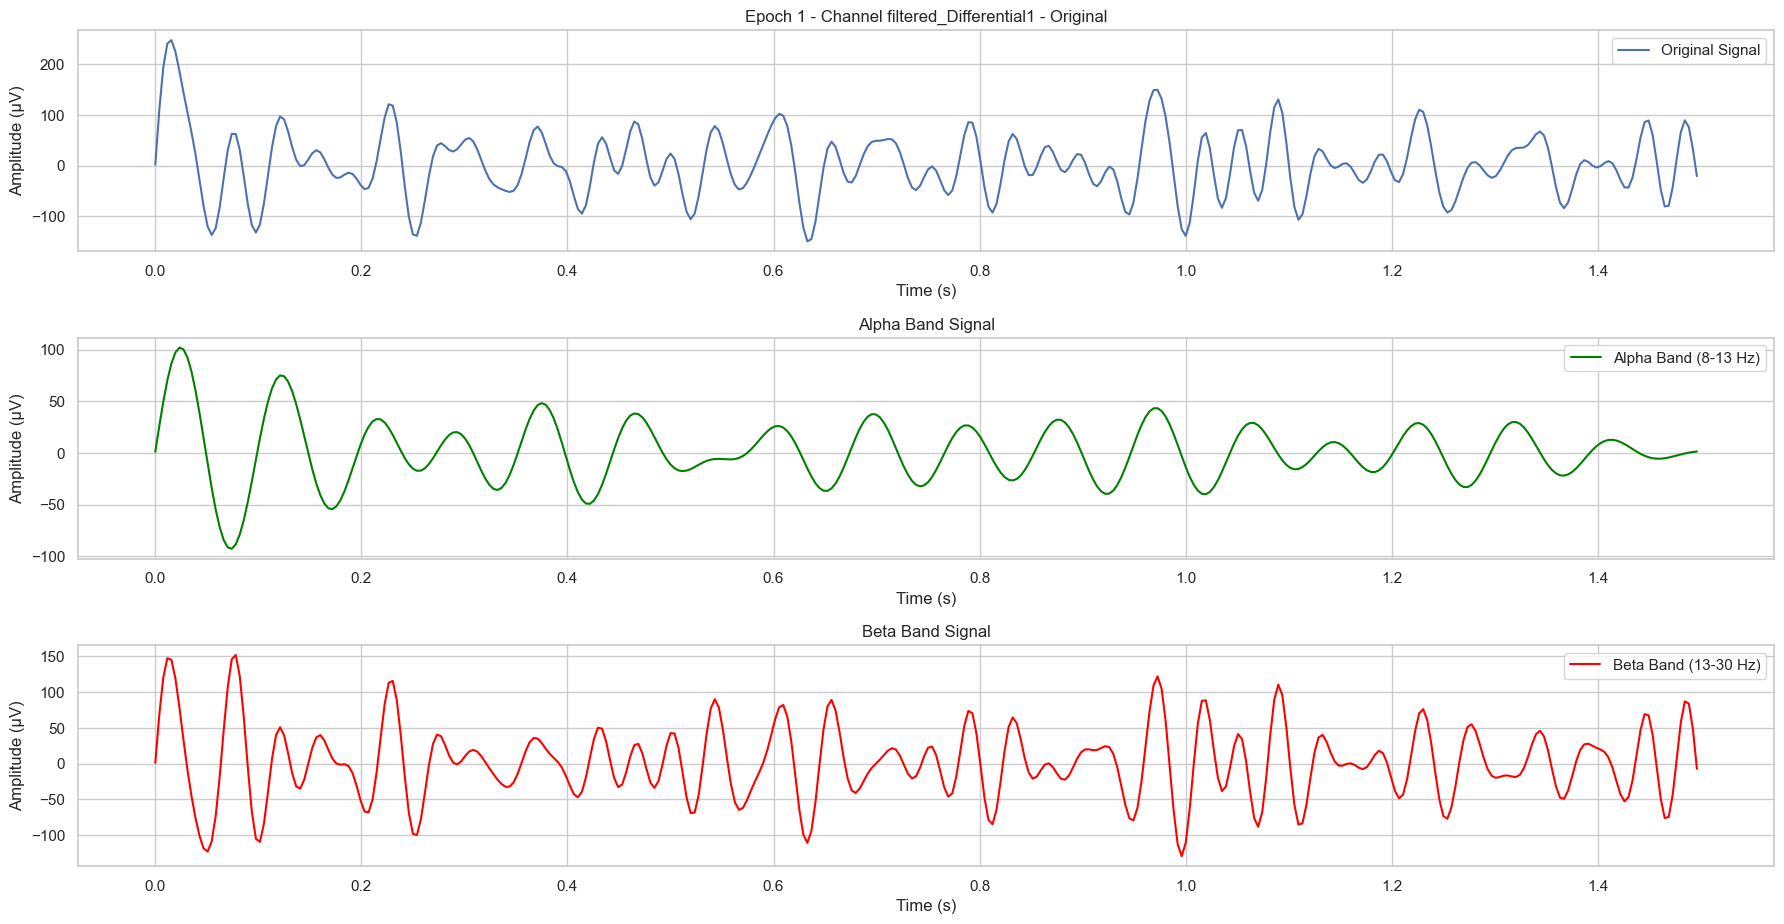

Combined PSD Features:
   Alpha_Ch1  Alpha_Ch2  Alpha_Ch3   Beta_Ch1   Beta_Ch2   Beta_Ch3
0   4.363037  12.038412  17.781540  17.498588  28.608174  34.092174
1   2.396430  11.423040   4.201359  12.376984  16.279285  24.866651
2   4.209619   8.269996  33.708339  13.927648  26.569372  28.317750
3   4.228029   9.361887   5.383765  15.514275  18.979668  18.222479
4   3.598950   1.124003   5.762757  10.345521  11.781172  15.791177
Alpha and Beta PSD features saved to ./eeg_alpha_beta_psd_features.csv


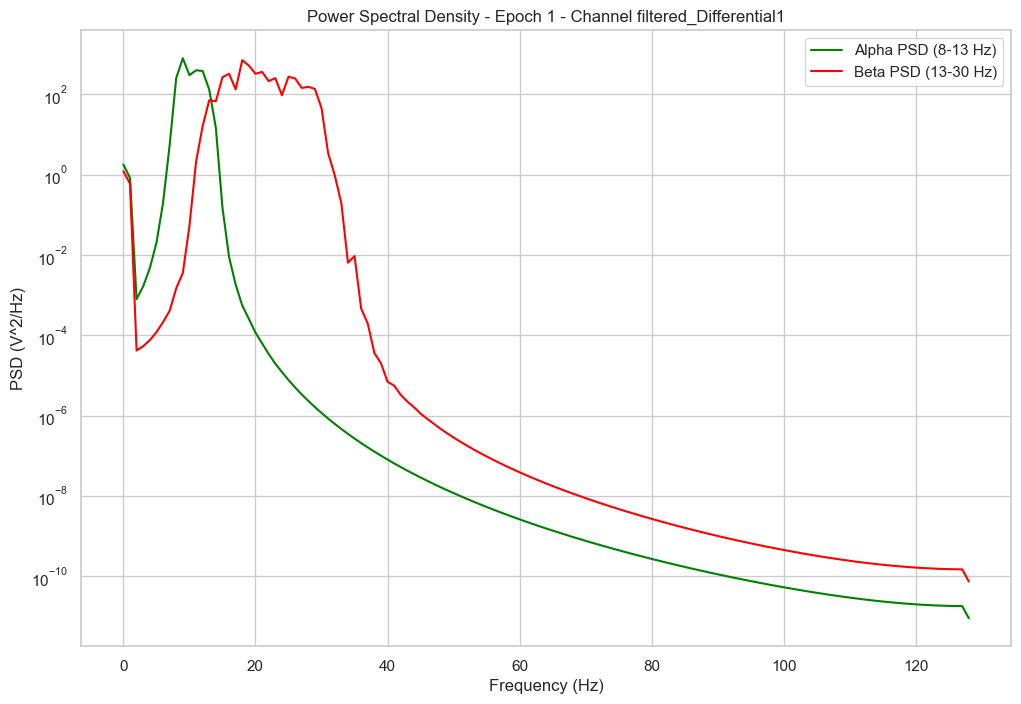

In [71]:
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt, welch
import matplotlib.pyplot as plt

# Step 1: Load and Verify Your Data
#filtered_csv_path = './eeg_data_filtered.csv'
#df_filtered = pd.read_csv(filtered_csv_path)
selected_columns = ['filtered_Differential1', 'filtered_Differential2', 'filtered_Differential3']
df_eeg = df[selected_columns]

# Step 2: Define Frequency Bands and Filter Parameters
fs = 256
alpha_band = (8, 13)
beta_band = (13, 30)
nyq = 0.5 * fs
alpha_low = alpha_band[0] / nyq
alpha_high = alpha_band[1] / nyq
beta_low = beta_band[0] / nyq
beta_high = beta_band[1] / nyq
order = 5

# Step 3: Design Band-Pass Filters Using SciPy
b_alpha, a_alpha = butter(order, [alpha_low, alpha_high], btype='band')
b_beta, a_beta = butter(order, [beta_low, beta_high], btype='band')

# Step 4: Apply Filters to Isolate Alpha, Beta Waves
data = df_eeg.values
epoch_length_sec = 1.5
epoch_length_samples = int(epoch_length_sec * fs)
n_samples = data.shape[0]
n_epochs = n_samples // epoch_length_samples
truncated_length = n_epochs * epoch_length_samples
data = data[:truncated_length]
epochs = data.reshape(n_epochs, epoch_length_samples, -1)

epochs_alpha = np.zeros_like(epochs)
epochs_beta = np.zeros_like(epochs)


for i in range(n_epochs):
    for ch in range(epochs.shape[2]):
        epochs_alpha[i, :, ch] = filtfilt(b_alpha, a_alpha, epochs[i, :, ch])
        epochs_beta[i, :, ch] = filtfilt(b_beta, a_beta, epochs[i, :, ch])

# Step 5: Visualize the Filtered Signals
epoch_idx = 0
channel_idx = 0
t = np.arange(0, epoch_length_sec, 1/fs)
original_signal = epochs[epoch_idx, :, channel_idx]
alpha_signal = epochs_alpha[epoch_idx, :, channel_idx]
beta_signal = epochs_beta[epoch_idx, :, channel_idx]


plt.figure(figsize=(18, 12))

plt.subplot(4, 1, 1)
plt.plot(t, original_signal, label='Original Signal')
plt.title(f'Epoch {epoch_idx+1} - Channel {selected_columns[channel_idx]} - Original')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.legend()
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(t, alpha_signal, color='green', label='Alpha Band (8-13 Hz)')
plt.title('Alpha Band Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.legend()
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(t, beta_signal, color='red', label='Beta Band (13-30 Hz)')
plt.title('Beta Band Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Step 6: Compute Power Spectral Density (PSD)
def compute_psd(data, fs):
    n_epochs = data.shape[0]
    psd_list = []
    for i in range(n_epochs):
        f, Pxx = welch(data[i, :], fs=fs, nperseg=fs)
        psd_list.append(Pxx)
    psd_array = np.array(psd_list)
    return f, psd_array

psd_alpha = {}
psd_beta = {}

for ch in range(epochs.shape[2]):
    # Alpha PSD
    f_alpha, Pxx_alpha = compute_psd(epochs_alpha[:, :, ch], fs)
    psd_alpha[f'Alpha_Ch{ch+1}'] = Pxx_alpha.mean(axis=1)
    
    # Beta PSD
    f_beta, Pxx_beta = compute_psd(epochs_beta[:, :, ch], fs)
    psd_beta[f'Beta_Ch{ch+1}'] = Pxx_beta.mean(axis=1)
    

# Step 7: Extract Features for Machine Learning
df_features = pd.DataFrame()

# Add Alpha features
for key in psd_alpha:
    df_features[key] = psd_alpha[key]

# Add Beta features
for key in psd_beta:
    df_features[key] = psd_beta[key]


print("Combined PSD Features:")
print(df_features.head())

# Step 8: Save Features to CSV
# Optional: Add labels
# labels = np.array([...])  # Replace with your actual labels
# df_features['Label'] = labels

features_csv_path = './eeg_alpha_beta_psd_features.csv'
df_features.to_csv(features_csv_path, index=False)
print(f'Alpha and Beta PSD features saved to {features_csv_path}')

# Optional: Visualization of PSD for a single epoch and channel
plt.figure(figsize=(12, 8))
plt.semilogy(f_alpha, Pxx_alpha[epoch_idx], label='Alpha PSD (8-13 Hz)', color='green')
plt.semilogy(f_beta, Pxx_beta[epoch_idx], label='Beta PSD (13-30 Hz)', color='red')
plt.title(f'Power Spectral Density - Epoch {epoch_idx+1} - Channel {selected_columns[channel_idx]}')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V^2/Hz)')
plt.legend()
plt.grid(True)
plt.show()
